In [118]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
from sklearn import metrics
from sklearn import preprocessing

import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
import joblib
pd.set_option('display.max_columns', 100)

In [52]:
def plot_lift(y_real, y_proba, ax = None, color = 'b', title = 'Lift Curve'):
    # Prepare the data
    aux_df = pd.DataFrame()
    aux_df['y_real'] = y_real
    aux_df['y_proba'] = y_proba
    # Sort by predicted probability
    aux_df = aux_df.sort_values('y_proba', ascending = False)
    # Find the total positive ratio of the whole dataset
    total_positive_ratio = sum(aux_df['y_real'] == 1) / aux_df.shape[0]
    # For each line of data, get the ratio of positives of the given subset and calculate the lift
    lift_values = []
    for i in aux_df.index:
        threshold = aux_df.loc[i]['y_proba']
        subset = aux_df[aux_df['y_proba'] >= threshold]
        subset_positive_ratio = sum(subset['y_real'] == 1) / subset.shape[0]
        lift = subset_positive_ratio / total_positive_ratio
        lift_values.append(lift)
    # Plot the lift curve
    if ax == None:
        ax = plt.axes()
    ax.set_xlabel('Proportion of sample')
    ax.set_ylabel('Lift')
    ax.set_title(title)
    sns.lineplot(x = [x/len(lift_values) for x in range(len(lift_values))], y = lift_values, ax = ax, color = color)
    ax.axhline(1, color = 'gray', linestyle = 'dashed', linewidth = 3)

In [117]:
def winsorizer(data, attrs, params=None):
    """Replace outliers with top and bottom value

    Args:
        data (Pandas dataframe): imput dataset
        attrs (list): what variables want to trim their outlier's values
        params (None, optional):  Defaults to None.

    Returns:
        Pandas dataframe: Return dataset with attrs without outliers 
    """
    for x in attrs:
        q75,q25 = np.percentile(data.loc[:,x],[75,25])
        intr_qr = q75-q25
    
        max = q75+(1.5*intr_qr)
        min = q25-(1.5*intr_qr)
    
        data.loc[data[x] < min,x] = min
        data.loc[data[x] > max,x] = max
    
    return data

## Set parameters

Here we set few parameters for the analysis and models.

In [89]:
RFC_METRIC = 'gini'  #metric 
NUM_ESTIMATORS = 100 #number of estimators 
NO_JOBS = 4 #number of parallel jobs used 

#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result
LABEL = "target"

import os

PATH="data/credit_card_clients.csv"


In [15]:
metrics_score = {
"roc_auc": metrics.roc_auc_score,
"accuracy": metrics.accuracy_score
}


models = dict()

In [74]:
def train_cv(model, df, metric, predictors=None):
   

    folds =-1
    models = []

    if 'kfold' in df.columns:
        folds = df.kfold.max()

    if folds != -1:

        cv_val_result = []
        for fold in range(folds + 1):
            # training data is where kfold is not equal to provided fold 
            # also, note that we reset the index
            df_train = df[df.kfold != fold].reset_index(drop=True)

            # validation data is where kfold is equal to provided fold
            df_valid = df[df.kfold == fold].reset_index(drop=True) # drop the label and kfold column from dataframe and convert it to
            
            # Because train and validation data does not have the same number of columns, we will align them.
            df_train, df_valid = df_train.align(df_valid, join='outer', axis=1, fill_value=0)

            # a numpy array by using .values.
            # target is label column in the dataframe
            x_train = df_train.drop([LABEL, 'kfold'], axis=1).values 
            y_train = df_train[LABEL].values
            
            # similarly, for validation, we have
            x_valid = df_valid.drop([LABEL, 'kfold'], axis=1).values 
            y_valid = df_valid[LABEL].values
            

            # fit the model on training data
            model.fit(x_train, y_train)

            # create predictions for validation samples
            preds = model.predict(x_valid)


            # calculate & print metric
            metricfun = metrics_score[metric]
            result = metricfun(y_valid, preds) 
            print(f"Fold={fold}, {metric}={result}")

            cv_val_result.append(result)

            # calling garbage collector
            gc.collect()
            

            # save the model fold model
            models.append(model)
            #joblib.dump( model, f"models/{model}_{fold}.bin")

            
        print(f'CV model - {metric} - mean=%.3f - std=(%.3f)' % (np.mean(cv_val_result), np.std(cv_val_result)))

        return models
    


# <a id="3">Read the data</a>

In [4]:
data_df = pd.read_csv(PATH)

In [6]:
data_df.head()

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,target,kfold
0,27063,290000,1,3,2,41,0,0,0,0,0,0,293281,268030,157691,158720,144085,143663,7948,22429,5530,4442,5887,5890,0,0
1,6786,80000,2,3,1,42,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,12263,50000,2,2,1,25,1,2,0,0,0,0,19454,18856,19590,18861,4581,2158,0,1200,477,121,22,0,0,0
3,16349,500000,2,1,2,34,-2,-2,-2,-2,-2,-2,11765,6599,11421,-83,49699,3821,6648,11986,0,49947,3840,11939,0,0
4,1500,20000,1,1,2,27,1,2,-1,-1,0,0,6274,5971,3980,9040,9040,0,0,4000,9040,0,0,17291,0,0


# <a id="4">Check the data</a>

In [8]:
print("Default Credit Card Clients data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

Default Credit Card Clients data -  rows: 30000  columns: 26


# <a id="6">Predictive models</a>  



### Define predictors and target values

Let's define the predictor features and the target features. Categorical features, if any, are also defined. In our case, there are no categorical feature.

In [7]:
target = 'target'
predictors = [  'limit_bal',
 'sex',
 'education',
 'marriage',
 'age',
 'pay_0',
 'pay_2',
 'pay_3',
 'pay_4',
 'pay_5',
 'pay_6',
 'bill_amt2',
 'bill_amt4',
 'bill_amt6',
 'pay_amt1',
 'pay_amt2',
 'pay_amt3',
 'pay_amt4',
 'pay_amt5',
 'pay_amt6']

### Split data in train and validation using kfold



In [10]:
data_df.groupby('kfold').agg({'id': 'count', 'target': 'sum'})

,id,target
kfold,,
0,6000,1327
1,6000,1327
2,6000,1327
3,6000,1327
4,6000,1328


We also make copies of the train_df and val_df for later usage.

In [24]:
train_df_bkp = train_df.copy()
val_df_bkp = val_df.copy()

Let's start with a RandomForrestClassifier <a href='#8'>[3]</a>   model.

## <a id="61">RandomForestClassifier</a>




Let's run a model using the training set for training. Then, we will use the validation set for validation. 

### Metric

We will use as validation criterion **GINI**, which formula is **GINI = 2 * (AUC) - 1**, where **AUC** is the **Receiver Operating Characteristic - Area Under Curve (ROC-AUC)** <a href='#8'>[4]</a>.  Number of estimators is set to **100** and number of parallel jobs is set to **4**.

We start by initializing the RandomForestClassifier.

In [28]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)


Let's train the **RandonForestClassifier** using the **train_df** data and **fit** function.

In [54]:
clf_models = train_cv(clf, data_df[predictors + ['kfold',LABEL]], 'roc_auc')


Fold=0, roc_auc=0.6714045847886599
Fold=1, roc_auc=0.6673577032096554
Fold=2, roc_auc=0.6535746808898012
Fold=3, roc_auc=0.6465318652213464
Fold=4, roc_auc=0.645228172965836
CV model - roc_auc - mean=0.657 - std=(0.011)


Let's now predict the **target** values for the **val_df** data, using **predict** function.

Let's also visualize the features importance.

### Features importance

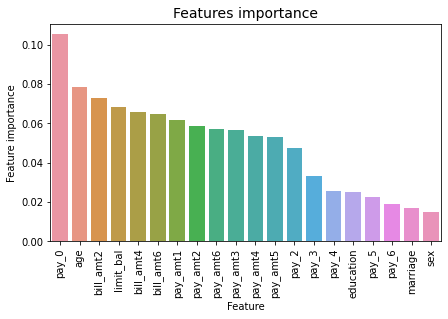

In [55]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': np.mean([clf.feature_importances_ for clf in clf_models], axis=0)})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   


The most important features are **PAY_0**, **AGE**, **BILL_AMT2**, **LIMIT_BAL**, **BILL_AMT4**, **BILL_AMT6**.


### Lift 

Let's see the lift graph with the model we got

/Users/galissa/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


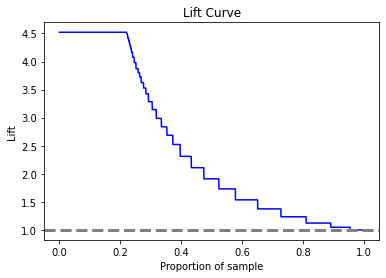

In [62]:
FOLD = 0
plot_lift(y_real=data_df[data_df.kfold==FOLD][LABEL],y_proba=clf_models[0].predict_proba(data_df[data_df.kfold==FOLD][predictors])[:,1])

/Users/galissa/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


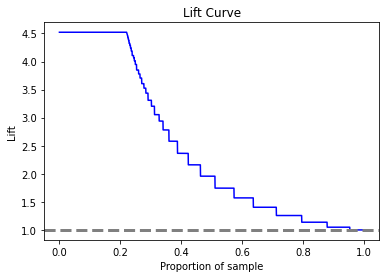

In [63]:
FOLD = 2
plot_lift(y_real=data_df[data_df.kfold==FOLD][LABEL],y_proba=clf_models[0].predict_proba(data_df[data_df.kfold==FOLD][predictors])[:,1])

/Users/galissa/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


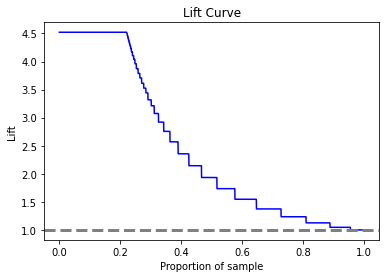

In [65]:
FOLD = 3
plot_lift(y_real=data_df[data_df.kfold==FOLD][LABEL],y_proba=clf_models[0].predict_proba(data_df[data_df.kfold==FOLD][predictors])[:,1])

/Users/galissa/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


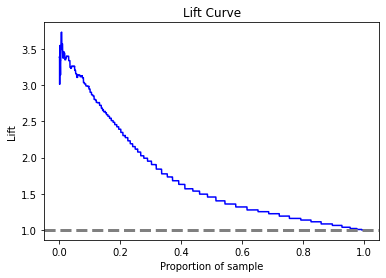

In [64]:
FOLD = 4
plot_lift(y_real=data_df[data_df.kfold==FOLD][LABEL],y_proba=clf_models[0].predict_proba(data_df[data_df.kfold==FOLD][predictors])[:,1])

The **ROC-AUC** score obtained with **RandomForrestClassifier** is **0.66**.


Let's use for RandomForrestClassifier **dummified variables** for the **categorical features**.


We start by defining the categorical features.


### RandomForrest with OneHotEncoder

In [66]:
cat_features = ['education', 'sex', 'marriage']

In [67]:
data_ohe_df = pd.get_dummies(data_df, columns = cat_features)


In [68]:
print("Default of Credit Card Clients train data -  rows:",data_ohe_df.shape[0]," columns:", data_ohe_df.shape[1])


Default of Credit Card Clients train data -  rows: 30000  columns: 36


In [69]:
data_ohe_df.head(5)

,id,limit_bal,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,target,kfold,education_0,education_1,education_2,education_3,education_4,education_5,education_6,sex_1,sex_2,marriage_0,marriage_1,marriage_2,marriage_3
0,27063,290000,41,0,0,0,0,0,0,293281,268030,157691,158720,144085,143663,7948,22429,5530,4442,5887,5890,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
1,6786,80000,42,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
2,12263,50000,25,1,2,0,0,0,0,19454,18856,19590,18861,4581,2158,0,1200,477,121,22,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
3,16349,500000,34,-2,-2,-2,-2,-2,-2,11765,6599,11421,-83,49699,3821,6648,11986,0,49947,3840,11939,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
4,1500,20000,27,1,2,-1,-1,0,0,6274,5971,3980,9040,9040,0,0,4000,9040,0,0,17291,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0


Let's define the target and predictors lists.

In [72]:
predictors_ohe = [
              'limit_bal', 'age', 'pay_0', 'pay_2', 'pay_3',
              'pay_4', 'pay_5', 'pay_6', 'bill_amt2', 'bill_amt4', 'bill_amt6', 'pay_amt1',
              'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6',
              'education_0', 'education_1', 'education_2', 'education_3', 'education_4',
              'education_5', 'education_6', 'sex_1', 'sex_2', 'marriage_0',
              'marriage_1', 'marriage_2', 'marriage_3'
              ]

Let's train the **RandonForestClassifier** using the **train_fa_df** data and **fit** function.

In [76]:

clf_models = train_cv(clf, data_ohe_df[predictors_ohe + ['kfold',LABEL]], 'roc_auc')


Fold=0, roc_auc=0.6790939823137003
Fold=1, roc_auc=0.6683718828570098
Fold=2, roc_auc=0.6513697391950519
Fold=3, roc_auc=0.6520255130121877
Fold=4, roc_auc=0.6463499546129724
CV model - roc_auc - mean=0.659 - std=(0.012)


Let's also visualize the features importance. 

#### Features importance

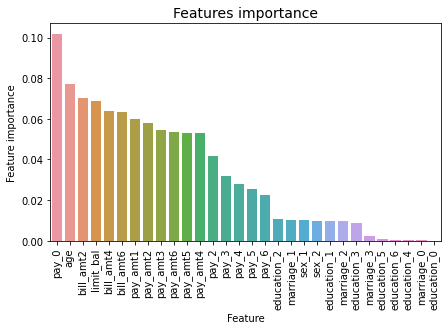

In [78]:
tmp = pd.DataFrame({'Feature': predictors_ohe, 'Feature importance': np.mean([clf.feature_importances_ for clf in clf_models], axis=0)})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   


The most important features are **AGE**, **LIMIT_BAL**, **BILL_AMT1**, **PAY_0_2**, **BILL_AMT2**, **BILL_AMT3**.

#### Lift curve

Let's show a confusion matrix for the results we obtained. 

/Users/galissa/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


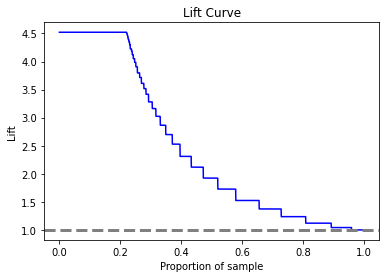

In [80]:
FOLD = 0
plot_lift(y_real=data_ohe_df[data_ohe_df.kfold==FOLD][LABEL],y_proba=clf_models[0].predict_proba(data_ohe_df[data_ohe_df.kfold==FOLD][predictors_ohe])[:,1])

/Users/galissa/miniconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


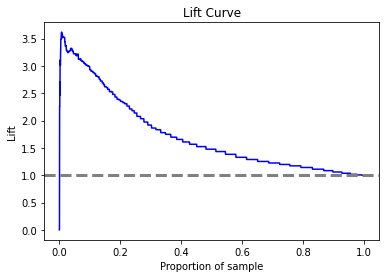

In [82]:
FOLD = 4
plot_lift(y_real=data_ohe_df[data_ohe_df.kfold==FOLD][LABEL],
        y_proba=clf_models[0].predict_proba(data_ohe_df[data_ohe_df.kfold==FOLD][predictors_ohe])[:,1])

With the dummified features, the improvement of the AUC score is quite small.

## <a id="63">Logist Regression</a>


Logist Regression  is a gradient boosting for decision trees algorithm with support for handling categorical data <a href='#8'>[6]</a>.

### Prepare the model

Let's set the parameters for the model and initialize the model.

In [132]:
data_ohe_df = winsorizer(data_ohe_df, predictors_ohe[0:17])

In [136]:
data_norm_df = preprocessing.normalize(data_ohe_df[predictors_ohe[:17]], axis=0)
data_norm_df = pd.DataFrame(data_norm_df, columns=predictors_ohe[:17])

In [141]:
data_norm_df = data_norm_df.join(data_ohe_df[predictors_ohe[17:]]).join(data_df[["kfold", LABEL]])


In [152]:
clf = LogisticRegression(solver='liblinear', random_state=0)

In [153]:
data_norm_df[predictors_ohe + ['kfold',LABEL]].groupby("kfold").target.sum()

kfold
0    1327
1    1327
2    1327
3    1327
4    1328
Name: target, dtype: int64

In [157]:
clf_models = train_cv(clf, data_ohe_df[predictors_ohe + ['kfold',LABEL]], 'roc_auc')

Fold=0, roc_auc=0.5029631171776617
Fold=1, roc_auc=0.5017257502776535
Fold=2, roc_auc=0.5021537408618607
Fold=3, roc_auc=0.5007023786697491
Fold=4, roc_auc=0.5005389709523024
CV model - roc_auc - mean=0.502 - std=(0.001)


In [155]:
from sklearn.linear_model import Lasso

In [158]:
lasso = Lasso(alpha=1.0)
clf_models = train_cv(lasso, data_ohe_df[predictors_ohe + ['kfold',LABEL]], 'roc_auc')

Fold=0, roc_auc=0.6718085472654644
Fold=1, roc_auc=0.6783568515825734
Fold=2, roc_auc=0.6752358584509031
Fold=3, roc_auc=0.6645452858062745
Fold=4, roc_auc=0.6532538275963442
CV model - roc_auc - mean=0.669 - std=(0.009)


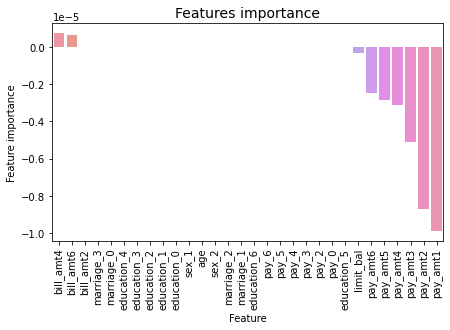

In [162]:
tmp = pd.DataFrame({'Feature': predictors_ohe, 'Feature importance': np.mean([clf.coef_ for clf in clf_models], axis=0)})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   


## <a id="63">CatBoostClassifier</a>


CatBoostClassifier is a gradient boosting for decision trees algorithm with support for handling categorical data <a href='#8'>[6]</a>.

### Prepare the model

Let's set the parameters for the model and initialize the model.

In [92]:
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [93]:
clf_models = train_cv(clf, data_df[predictors + ['kfold',LABEL]], 'roc_auc')


0:	total: 156ms	remaining: 1m 17s
50:	total: 4.49s	remaining: 39.5s
100:	total: 8.27s	remaining: 32.7s
150:	total: 12s	remaining: 27.8s
200:	total: 15.9s	remaining: 23.7s
250:	total: 19.5s	remaining: 19.4s
300:	total: 23.2s	remaining: 15.4s
350:	total: 26.9s	remaining: 11.4s
400:	total: 30.8s	remaining: 7.6s
450:	total: 34.6s	remaining: 3.76s
499:	total: 38.2s	remaining: 0us
Fold=0, roc_auc=0.6695534529438544
0:	total: 91.4ms	remaining: 45.6s
50:	total: 3.68s	remaining: 32.4s
100:	total: 7.31s	remaining: 28.9s
150:	total: 11s	remaining: 25.5s
200:	total: 14.8s	remaining: 21.9s
250:	total: 18.4s	remaining: 18.3s
300:	total: 22.2s	remaining: 14.7s
350:	total: 25.9s	remaining: 11s
400:	total: 29.5s	remaining: 7.29s
450:	total: 33.3s	remaining: 3.61s
499:	total: 37s	remaining: 0us
Fold=1, roc_auc=0.6639528075069613
0:	total: 92.4ms	remaining: 46.1s
50:	total: 3.56s	remaining: 31.3s
100:	total: 7.33s	remaining: 28.9s
150:	total: 11s	remaining: 25.5s
200:	total: 14.8s	remaining: 22s
250:	tot

### Features importance

Let's see also the features importance.

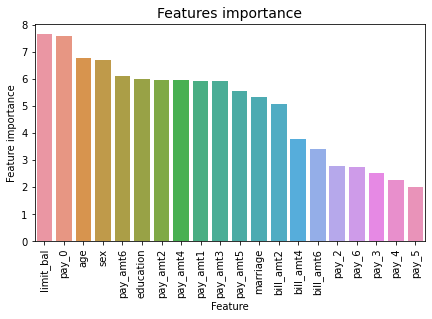

In [94]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': np.mean([clf.feature_importances_ for clf in clf_models], axis=0)})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   


### Lift curve

Let's visualize the confusion matrix.

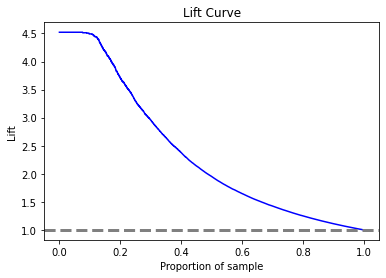

In [95]:
FOLD = 0
plot_lift(y_real=data_df[data_df.kfold==FOLD][LABEL],y_proba=clf_models[0].predict_proba(data_df[data_df.kfold==FOLD][predictors])[:,1])

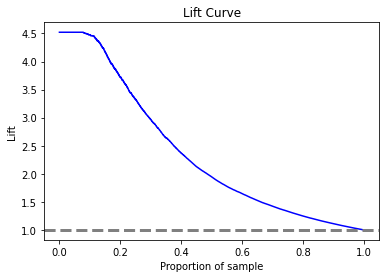

In [96]:
FOLD = 1
plot_lift(y_real=data_df[data_df.kfold==FOLD][LABEL],y_proba=clf_models[0].predict_proba(data_df[data_df.kfold==FOLD][predictors])[:,1])

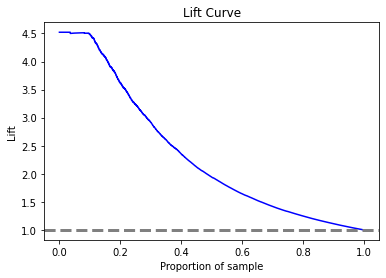

In [97]:
FOLD = 2
plot_lift(y_real=data_df[data_df.kfold==FOLD][LABEL],y_proba=clf_models[0].predict_proba(data_df[data_df.kfold==FOLD][predictors])[:,1])

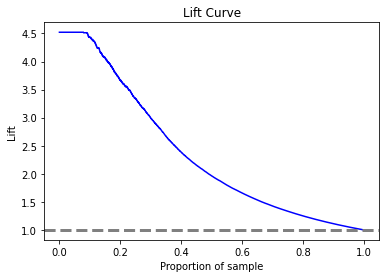

In [99]:
FOLD = 3
plot_lift(y_real=data_df[data_df.kfold==FOLD][LABEL],y_proba=clf_models[0].predict_proba(data_df[data_df.kfold==FOLD][predictors])[:,1])

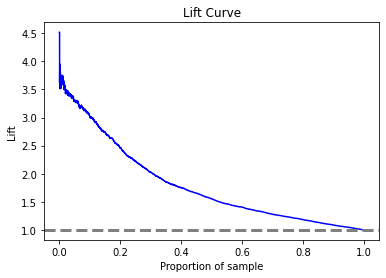

In [98]:
FOLD = 4
plot_lift(y_real=data_df[data_df.kfold==FOLD][LABEL],y_proba=clf_models[0].predict_proba(data_df[data_df.kfold==FOLD][predictors])[:,1])

The ROC-AUC score obtained with CatBoostClassifier is 0.66.

## <a id="64">XGBoost</a>

XGBoost is a gradient boosting algorithm <a href='#8'>[7]</a>.

Let's prepare the model.

### Prepare the model

We initialize the DMatrix objects for training and validation, starting from the datasets. We also set some of the parameters used for the model tuning.

In [56]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(val_df[predictors], val_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [101]:
clf = xgb.XGBClassifier(learning_rate =0.1,
 n_estimators=500,
 max_depth=3,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.9,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 eta=0.039,
 seed=27)

In [102]:
clf_models = train_cv(clf, data_df[predictors + ['kfold',LABEL]], 'roc_auc')


Fold=0, roc_auc=0.6717071938057152
Fold=1, roc_auc=0.6662555548872123
Fold=2, roc_auc=0.6580823699648013
Fold=3, roc_auc=0.6502301779805457
Fold=4, roc_auc=0.6484310529790395
CV model - roc_auc - mean=0.659 - std=(0.009)


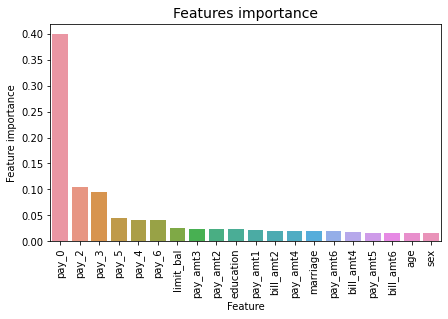

In [103]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': np.mean([clf.feature_importances_ for clf in clf_models], axis=0)})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   


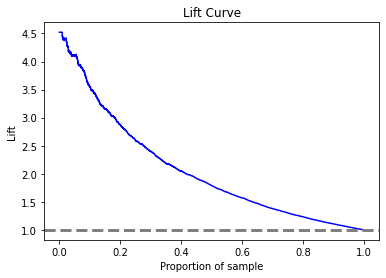

In [105]:
FOLD = 0
plot_lift(y_real=data_df[data_df.kfold==FOLD][LABEL],y_proba=clf_models[0].predict_proba(data_df[data_df.kfold==FOLD][predictors])[:,1])

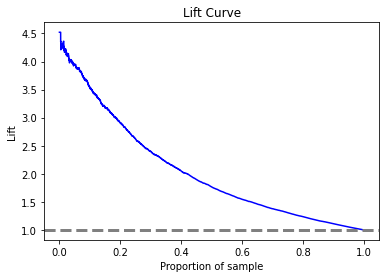

In [106]:
FOLD = 1
plot_lift(y_real=data_df[data_df.kfold==FOLD][LABEL],y_proba=clf_models[0].predict_proba(data_df[data_df.kfold==FOLD][predictors])[:,1])

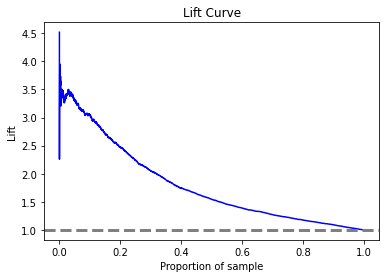

In [107]:
FOLD = 4
plot_lift(y_real=data_df[data_df.kfold==FOLD][LABEL],y_proba=clf_models[0].predict_proba(data_df[data_df.kfold==FOLD][predictors])[:,1])

The best validation score (ROC-AUC) was **0.78**, for round **453**.

## <a id="65">LightGBM</a>


Let's continue with another gradient boosting algorithm, LightGBM <a href='#8'>[7]</a> <a href='#8'>[8]</a>.


### Define model parameters

Let's set the parameters for the model.

In [168]:
clf = lgb.LGBMClassifier(**params)

In [171]:
clf = lgb.LGBMClassifier(n_estimators=500, max_depth=5,
                          verbose=-1,
                          learning_rate=0.03, reg_lambda=50,
                          min_child_samples=2400,
                          num_leaves=95,
                          max_bins=511, random_state=47,  n_jobs=-1)

In [172]:
clf_models = train_cv(clf, data_df[predictors + ['kfold',LABEL]], 'roc_auc')


Fold=0, roc_auc=0.6683114900635713
Fold=1, roc_auc=0.6683114900635713
Fold=2, roc_auc=0.6558774282700521
Fold=3, roc_auc=0.6469506638450035
Fold=4, roc_auc=0.651867315151015
CV model - roc_auc - mean=0.658 - std=(0.009)


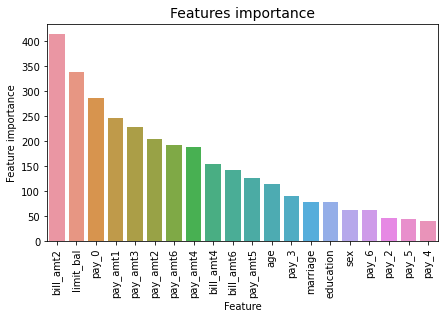

In [173]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': np.mean([clf.feature_importances_ for clf in clf_models], axis=0)})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()   


#### Lift curve

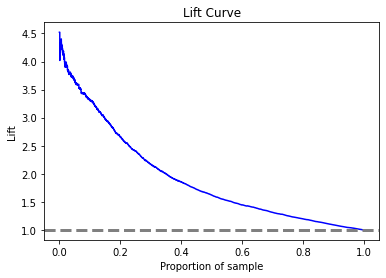

In [111]:
FOLD = 0
plot_lift(y_real=data_df[data_df.kfold==FOLD][LABEL],y_proba=clf_models[0].predict_proba(data_df[data_df.kfold==FOLD][predictors])[:,1])

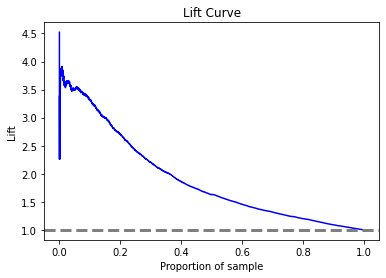

In [112]:
FOLD = 1
plot_lift(y_real=data_df[data_df.kfold==FOLD][LABEL],y_proba=clf_models[0].predict_proba(data_df[data_df.kfold==FOLD][predictors])[:,1])

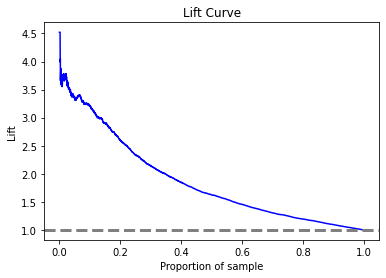

In [113]:
FOLD = 2
plot_lift(y_real=data_df[data_df.kfold==FOLD][LABEL],y_proba=clf_models[0].predict_proba(data_df[data_df.kfold==FOLD][predictors])[:,1])

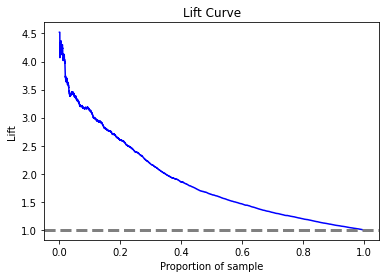

In [114]:
FOLD = 3
plot_lift(y_real=data_df[data_df.kfold==FOLD][LABEL],y_proba=clf_models[0].predict_proba(data_df[data_df.kfold==FOLD][predictors])[:,1])

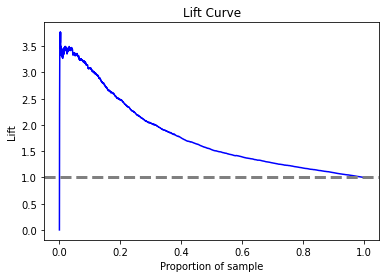

In [115]:
FOLD = 4
plot_lift(y_real=data_df[data_df.kfold==FOLD][LABEL],y_proba=clf_models[0].predict_proba(data_df[data_df.kfold==FOLD][predictors])[:,1])

### Feature Engineer

From the importance variable analysis we can see that some variables are good to discriminate the target, such as bill_amount, pay_ant, and so on. Let's see if we can create some news features from those variables and retrain a new model using the best algorith we have tested. 


In [177]:

pastpayment_vars = ['pay_0', 'pay_2', 
                    'pay_3', 'pay_4', 
                    'pay_5', 'pay_6']
data_df["pastpayment_acum"] = data_df[pastpayment_vars].sum(axis=1)

In [189]:
bill_amount_vars = ['bill_amt1', 'bill_amt2',
    'bill_amt3', 'bill_amt4', 
    'bill_amt5', 'bill_amt6']

data_df["bill_amount_acum"] = data_df[bill_amount_vars].sum(axis=1)


In [190]:
bill_amount_vars.reverse()
bill_amount_tend_df = data_df[bill_amount_vars].pct_change(axis="columns").replace(np.inf, 0).replace(np.nan, 0)

bill_amount_tend_df.rename(columns={"default payment next month": "target"}, inplace=True)

bill_amount_tend_df.columns = ['tend_bill_amt6', 'tend_bill_amt5', 'tend_bill_amt4', 'tend_bill_amt3', 'tend_bill_amt2',
       'tend_bill_amt1']

bill_amount_tend_df.drop("tend_bill_amt6", axis=1, inplace=True)

data_df = data_df.join(bill_amount_tend_df)


In [201]:
data_df

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,target,kfold,pastpayment_acum,bill_amount_acum,tend_bill_amt5,tend_bill_amt4,tend_bill_amt3,tend_bill_amt2,tend_bill_amt1,payment_amount_acum
0,27063,290000,1,3,2,41,0,0,0,0,0,0,293281,268030,157691,158720,144085,143663,7948,22429,5530,4442,5887,5890,0,0,0,1165470,0.002937,0.101572,-0.006483,0.699717,0.094210,52126
1,6786,80000,2,3,1,42,-2,-2,-2,-2,-2,-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-12,0,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,12263,50000,2,2,1,25,1,2,0,0,0,0,19454,18856,19590,18861,4581,2158,0,1200,477,121,22,0,0,0,3,83500,1.122799,3.117223,0.038651,-0.037468,0.031714,1820
3,16349,500000,2,1,2,34,-2,-2,-2,-2,-2,-2,11765,6599,11421,-83,49699,3821,6648,11986,0,49947,3840,11939,0,0,-12,83222,12.006805,-1.001670,-138.602410,-0.422205,0.782846,84360
4,1500,20000,1,1,2,27,1,2,-1,-1,0,0,6274,5971,3980,9040,9040,0,0,4000,9040,0,0,17291,0,0,1,34305,0.000000,0.000000,-0.559735,0.500251,0.050745,30331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,23495,110000,2,1,2,32,0,0,0,-2,-2,-2,60558,30900,0,0,0,0,1900,0,0,0,0,0,0,4,-6,91458,0.000000,0.000000,0.000000,0.000000,0.959806,1900
29996,2302,230000,2,1,1,30,-1,-1,0,0,0,0,2212,17402,32450,17285,9766,9981,17402,20013,346,5000,8000,5000,1,4,-2,89096,-0.021541,0.769916,0.877350,-0.463729,-0.872888,55761
29997,12696,20000,2,3,2,38,-1,-1,2,0,-1,-1,12193,11242,8015,3668,3508,5278,5015,0,0,3508,5278,780,0,4,-2,43904,-0.335354,0.045610,1.185115,0.402620,0.084593,14581
29998,28101,210000,2,1,2,29,-1,-1,-1,-1,-1,-1,18662,6220,199,0,10024,-18,6224,199,200,10024,0,0,0,4,-6,35087,-557.888889,-1.000000,0.000000,30.256281,2.000322,16647


In [202]:
pay_amount_vars = ['pay_amt1', 'pay_amt2', 
'pay_amt3', 'pay_amt4', 
'pay_amt5', 'pay_amt6']

data_df[pay_amount_vars]

data_df["payment_amount_acum"] = data_df[pay_amount_vars].sum(axis=1)

In [203]:
pay_amount_vars.reverse()
pay_amount_tend_df = data_df[pay_amount_vars].pct_change(axis="columns").replace(np.inf, 0).replace(np.nan, 0)

pay_amount_tend_df.rename(columns={"default payment next month": "target"}, inplace=True)

pay_amount_tend_df.columns = ['tend_pay_amt6', 'tend_pay_amt5', 'tend_pay_amt4', 'tend_pay_amt3', 'tend_pay_amt2',
       'tend_pay_amt1']

pay_amount_tend_df.drop("tend_pay_amt6", axis=1, inplace=True)

#data_df = data_df.join(pay_amount_tend_df)

In [204]:
pay_amount_tend_df

,tend_pay_amt5,tend_pay_amt4,tend_pay_amt3,tend_pay_amt2,tend_pay_amt1
0,-0.000509,-0.245456,0.244935,3.055877,-0.645637
1,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,4.500000,2.942149,1.515723,-1.000000
3,-0.678365,12.007031,-1.000000,0.000000,-0.445353
4,-1.000000,0.000000,0.000000,-0.557522,-1.000000
...,...,...,...,...,...
29995,0.000000,0.000000,0.000000,0.000000,0.000000
29996,0.600000,-0.375000,-0.930800,56.841040,-0.130465
29997,5.766667,-0.335354,-1.000000,0.000000,0.000000
29998,0.000000,0.000000,-0.980048,-0.005000,30.276382


The average validation **AUC** for the 5 folds obtained was **0.78**, with values between **0.778** and **0.79**.

# <a id="7">Conclusions</a>

We investigated the data, checking for data unbalancing, visualizing the features and understanding the relationship between different features.   

We then investigated five predictive models:  
* We started with **RandomForrestClassifier**, for which we obtained an AUC scode of **0.66**. 
   For the **RandomForrestClassifier** we also experimented with **OneHotEncoder**, replacing the categorical features with dummified values (introducing one dummy variable for each category). The AUC score did not improved significantly in this case.
* Next we used  an **AdaBoostClassifier** model, with lower AUC score (**0.65**).   
* We followed with an **CatBoostClassifier** model, with lower AUC score (**0.66**).   
* Then we experimented with a **XGBoost** model, for which the AUC score obtained was **0.77**.   
* We then presented the data to a **LightGBM** model. We used both train-validation split and cross-validation to evaluate the model effectiveness to predict the target value, i.e. detecting if a credit card client  will default next month. With both methods for LightGBM the obtained values of AUC for the validation set were around **0.78**.

# <a id="8">References</a>

[1] Default Credit Card Clients Dataset,  https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset/  
[2] Principal Component Analysis, Wikipedia Page, https://en.wikipedia.org/wiki/Principal_component_analysis  
[3] RandomForrestClassifier, http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  
[4] ROC-AUC characteristic, https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve   
[5] AdaBoostClassifier, http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html   
[6] CatBoostClassifier, https://tech.yandex.com/catboost/doc/dg/concepts/python-reference_catboostclassifier-docpage/  
[7] XGBoost Python API Reference, http://xgboost.readthedocs.io/en/latest/python/python_api.html  
[8] LightGBM Python implementation, https://github.com/Microsoft/LightGBM/tree/master/python-package  
[9] LightGBM algorithm, https://www.microsoft.com/en-us/research/wp-content/uploads/2017/11/lightgbm.pdf   

